In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 读取数据

In [2]:
# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split('/')[-1].split('.')[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data

# 提取锂电池容量
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018'] # 4 个数据集的名字
dir_path = 'dataset/'

capacity, charge, discharge = {}, {}, {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    capacity[name] = getBatteryCapacity(data)              # 放电时的容量数据
    charge[name] = getBatteryValues(data, 'charge')        # 充电数据
    discharge[name] = getBatteryValues(data, 'discharge')  # 放电数据

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


# 放电容量-充放电周期

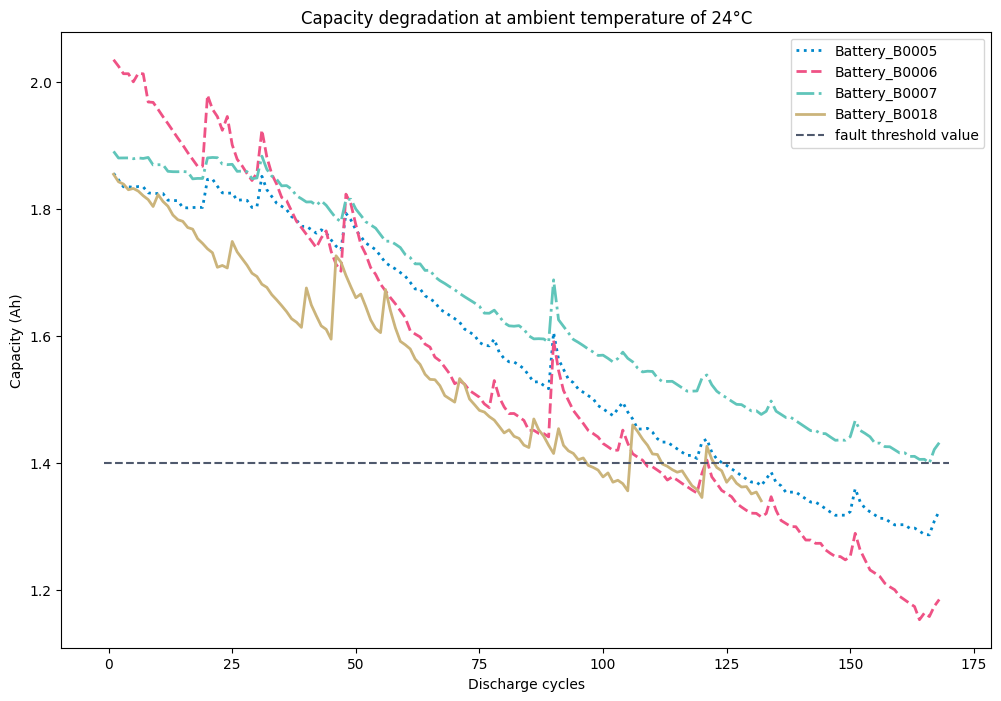

In [4]:
Rated_Capacity = 2.0
fig, ax = plt.subplots(1, figsize=(12, 8), dpi = 100)
color_list = ['#0087cb', '#ef5285', '#60c5ba', '#cbb47b']
line_list = [':', '--', '-.', '-']
for name,cl,ls in zip(Battery_list, color_list, line_list):
    data = capacity[name]
    ax.plot(data[0], data[1], c = cl, ls = ls, linewidth=2, label='Battery_'+name)
plt.plot([-1,170],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

# 电流和电压

## 充电
以 1.5A 的恒定电流（CC）模式进行充电，直到电池电压达到 4.2V，然后以恒定电压（CV）模式充电，直到充电电流降至 20mA。  

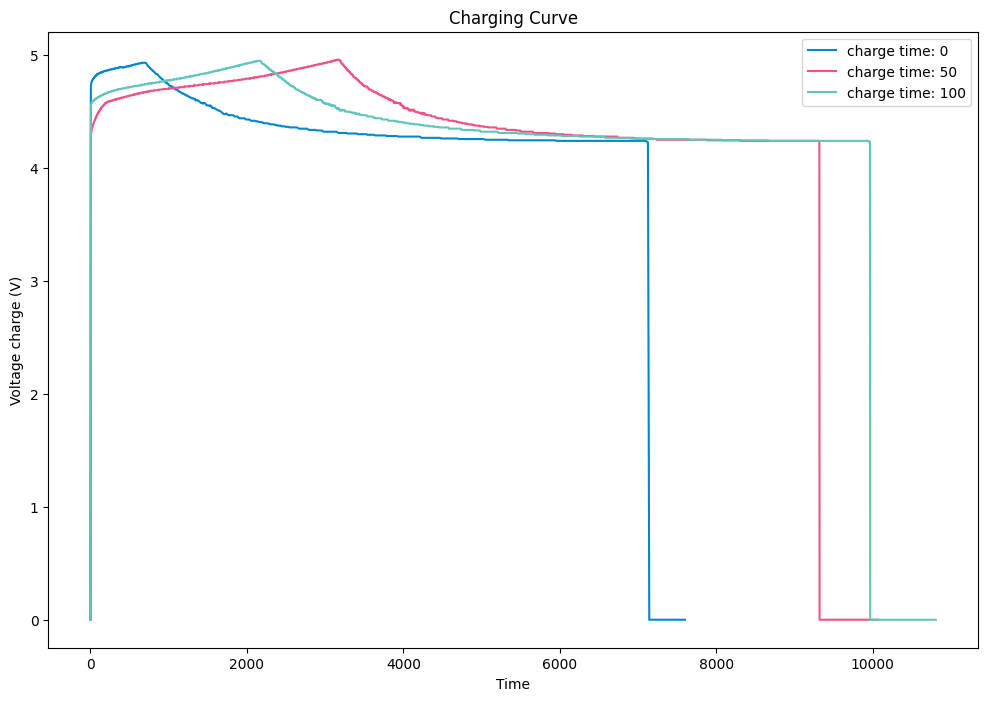

In [5]:
name = 'B0005'       #查看的电池号
time = [0, 50, 100] #查看的充电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8), dpi = 100)
color_list = ['#0087cb', '#ef5285', '#60c5ba']
c = 0
for t in time:
    Battery = charge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Voltage_charge'], color, label='charge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Voltage charge (V)', title='Charging Curve')
plt.legend()

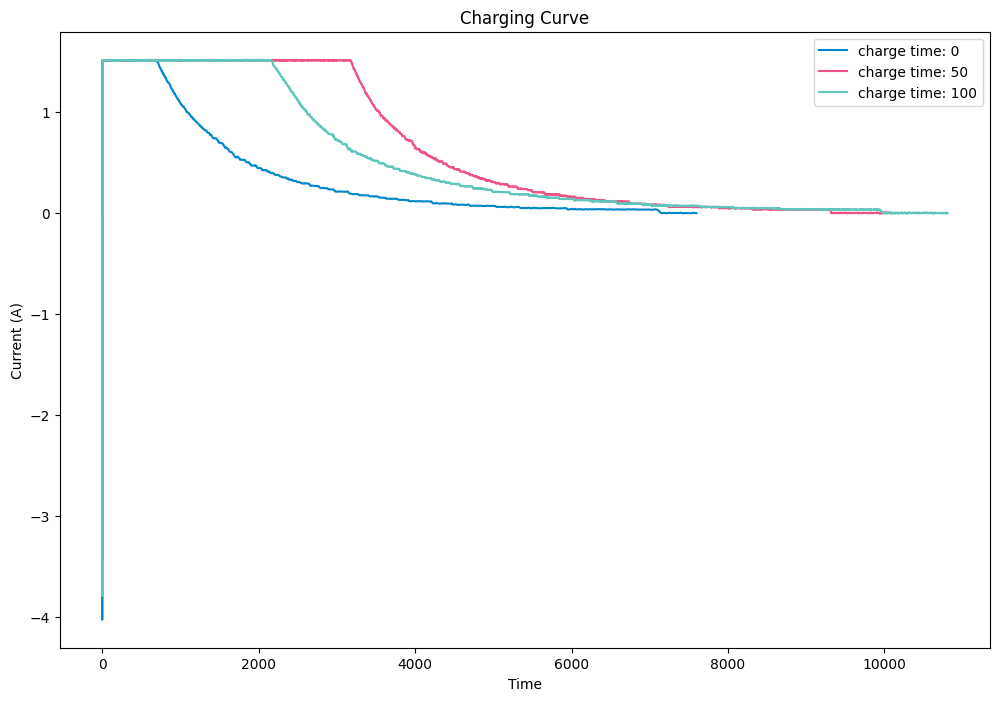

In [6]:
name = 'B0005'       #查看的电池号
time = [0, 50, 100] #查看的充电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8), dpi = 100)
color_list = ['#0087cb', '#ef5285', '#60c5ba']
c = 0
for t in time:
    Battery = charge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Current_measured'], color, label='charge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Current (A)', title='Charging Curve')
plt.legend()

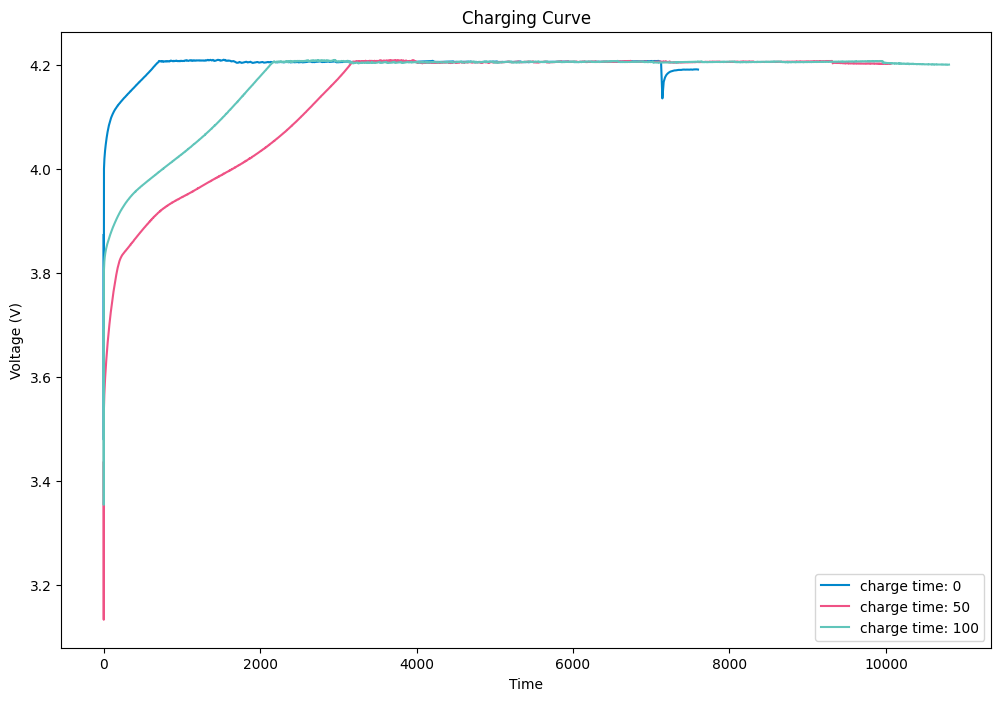

In [7]:
name = 'B0005'       #查看的电池号
time = [0, 50, 100] #查看的充电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8), dpi = 100)
color_list = ['#0087cb', '#ef5285', '#60c5ba']
c = 0
for t in time:
    Battery = charge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Voltage_measured'], color, label='charge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Voltage (V)', title='Charging Curve')
plt.legend()

## 放电
以 2A 的恒定电流（CC）模式进行放电，直到电池 5、6、7 和 18的电压降到 2.7V，2.5V，2.2V 和 2.5V。

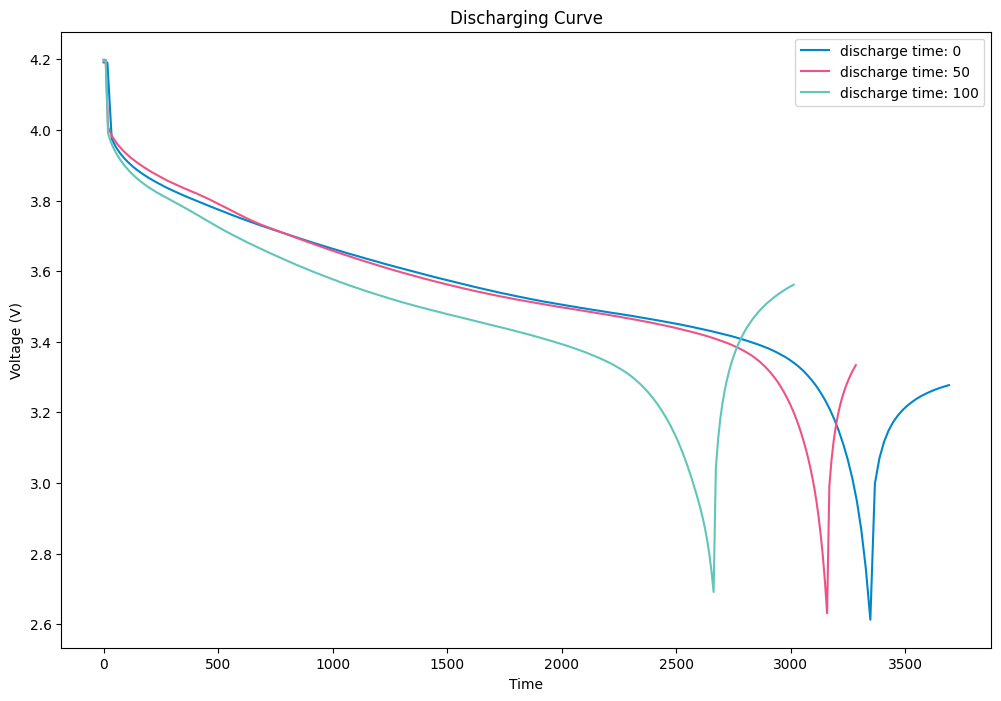

In [8]:
name = 'B0005'          #查看的电池号
time = [0, 50, 100]     #查看的放电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8), dpi = 100)
color_list = ['#0087cb', '#ef5285', '#60c5ba']
c = 0
for t in time:
    Battery = discharge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Voltage_measured'], color, label='discharge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Voltage (V)', title='Discharging Curve')
plt.legend()

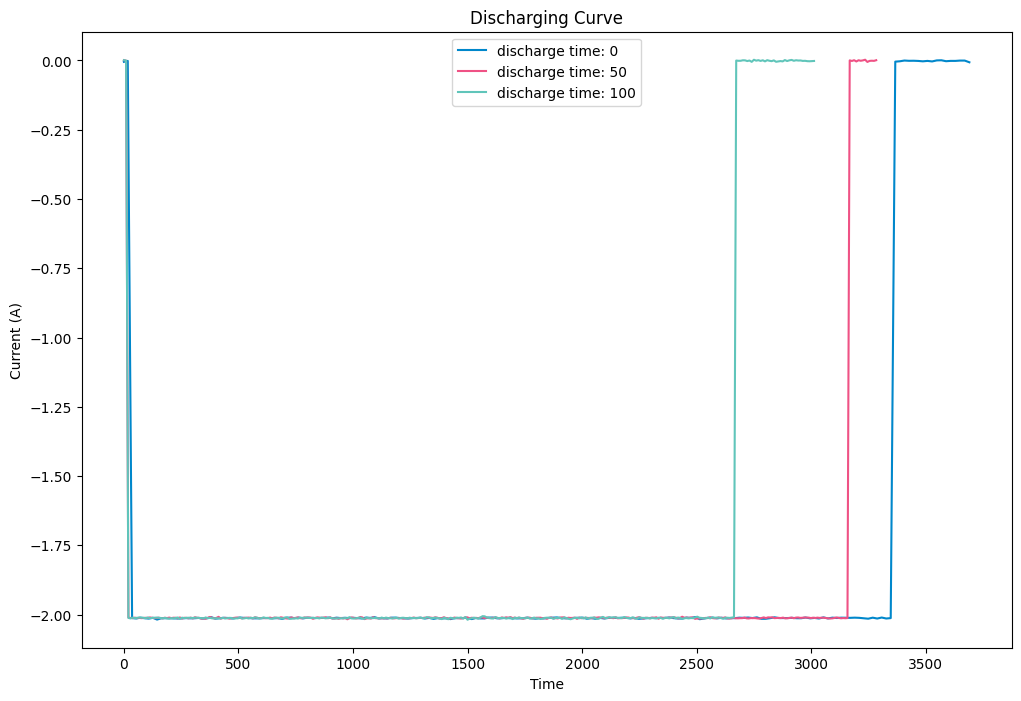

In [9]:
name = 'B0005'          #查看的电池号
time = [0, 50, 100]     #查看的放电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8), dpi = 100)
color_list = ['#0087cb', '#ef5285', '#60c5ba']
c = 0
for t in time:
    Battery = discharge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Current_measured'], color, label='discharge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Current (A)', title='Discharging Curve')
plt.legend()